1. На основе учебного ноутбука, проведите финальную подготовку данных. измените количество сегментирующих классов с `16` на `7`
 - 0_класс - FLOOR
 - 1_класс - CEILING
 - 2_класс - WALL
 - 3_класс - APERTURE, DOOR, WINDOW
 - 4_класс - COLUMN, RAILINGS, LADDER
 - 5_класс - INVENTORY
 - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Реализуйте сегментацию базы Стройка на основе модели `PSPnet`. Статья для изучения [Pyramid Scene Parsing Network](https://hszhao.github.io/projects/pspnet/) .


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

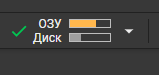


Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка


## Импорт библиотек
В этом блоке осуществляется импорт всех необходимых библиотек, используемых в проекте сегментации строительных объектов с применением нейросетевой архитектуры PSPNet.

Стандартные библиотеки:
- gc: управление сборщиком мусора для очистки оперативной памяти при необходимости.

- os: для навигации и взаимодействия с файловой системой.

- random: генерация случайных чисел (например, для перемешивания данных).

- time: замеры времени выполнения операций, профилирование.

Сторонние библиотеки:
- gdown: загрузка данных из Google Drive по прямым ссылкам (например, предобученных весов или датасета).

- matplotlib.pyplot: построение графиков и визуализация результатов (например, предсказаний модели).

- numpy: работа с массивами и матричными вычислениями.

- PIL.Image: базовая обработка изображений, преобразования и сохранение.

- sklearn.model_selection.train_test_split: разбиение данных на обучающую и тестовую выборки.

TensorFlow и Keras:
- Подключение модулей глубокого обучения для построения и обучения модели PSPNet:

- Базовые компоненты: tensorflow, tensorflow.keras.backend (например, для кастомных функций потерь или метрик).

- Архитектурные блоки (Conv2D, BatchNormalization, UpSampling2D и др.) — используются для построения кастомной архитектуры PSPNet.

- Model — определение модели с произвольной структурой.

- Adam — оптимизатор для обучения модели.

- tensorflow.keras.preprocessing.image — вспомогательные инструменты для обработки и загрузки изображений.

In [1]:
# Стандартные библиотеки
import gc  # очистка ОЗУ
import os  # для работы с файлами
import random  # генерация случайных чисел
import time  # работа со временем
import zipfile  # работа с zip-архивами

# Третьесторонние библиотеки
import gdown  # загрузка файлов по HTML ссылке
import matplotlib.pyplot as plt  # графики
import numpy as np  # численные вычисления
from PIL import Image  # работа с изображениями
from sklearn.model_selection import train_test_split  # разделение данных

# TensorFlow и Keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Activation,
    AveragePooling2D,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Cropping2D,
    Input,
    MaxPooling2D,
    UpSampling2D,
    ZeroPadding2D,
    concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

### Загрузка датасета

загружаем и распаковываем архив картинок

In [4]:
# Проверяем наличие архива
if not os.path.exists('construction_256x192.zip'):
    # Загрузка архива с датасетом
    gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=True)

# Распаковка архива в папку
# unzip -qo construction_256x192.zip -d construction_256x192
with zipfile.ZipFile('construction_256x192.zip', 'r') as zip_ref:
    zip_ref.extractall('construction_256x192')

# Просмотр содержимого папки
# ls construction_256x192
print("\n".join(os.listdir('construction_256x192')))

train
val


## Решение

**Функция преобразования RGB в метки классов, адаптированной под новую схему из 7 классов**

Этот блок содержит функцию rgb_to_labels, которая преобразует изображения масок, закодированных в формате RGB, в метки классов, соответствующие новой схеме с 7 укрупнёнными категориями. Преобразование необходимо для корректной подготовки обучающих и валидационных данных в задаче семантической сегментации.

Принцип работы функции - для каждого изображения из списка:

- Преобразуется RGB-маска в массив NumPy.

- Создаётся пустой массив меток (y) с размерами IMG_HEIGHT × IMG_WIDTH × 1.

- С помощью np.where и np.all определяются пиксели с определёнными цветами и присваиваются значения от 0 до 6 — согласно новой классификации.

Новое соответствие классов:
- 0 — FLOOR: (100, 100, 100)

- 1 — CEILING: (0, 0, 100)

- 2 — WALL: (0, 100, 0)

- 3 — APERTURE, DOOR, WINDOW: (0, 100, 100), (100, 0, 100), (100, 100, 0)

- 4 — COLUMN, RAILINGS, LADDER: (100, 0, 0), (0, 200, 0), (0, 0, 200)

- 5 — INVENTORY: (200, 0, 200)

- 6 — LAMP, WIRE, BEAM, EXTERNAL, BATTERY, PEOPLE: (200, 200, 0), (0, 100, 200), (100, 0, 200), (200, 200, 200), (200, 0, 0), (0, 200, 200)

In [ ]:
# Функция преобразования RGB в метки (адаптирована под 7 классов)
def rgb_to_labels(image_list):
    result = []
    for img in image_list:
        sample = np.array(img)  # Преобразуем изображение в массив NumPy
        y = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype='uint8')  # Инициализируем маску с метками

        # FLOOR (пол)
        y[np.where(np.all(sample == (100, 100, 100), axis=-1))] = 0

        # CEILING (потолок)
        y[np.where(np.all(sample == (0, 0, 100), axis=-1))] = 1

        # WALL (стена)
        y[np.where(np.all(sample == (0, 100, 0), axis=-1))] = 2

        # APERTURE / DOOR / WINDOW (проёмы, двери, окна)
        y[np.where(np.all(sample == (0, 100, 100), axis=-1))] = 3
        y[np.where(np.all(sample == (100, 0, 100), axis=-1))] = 3
        y[np.where(np.all(sample == (100, 100, 0), axis=-1))] = 3

        # COLUMN / RAILINGS / LADDER (колонны, перила, лестницы)
        y[np.where(np.all(sample == (100, 0, 0), axis=-1))] = 4
        y[np.where(np.all(sample == (0, 200, 0), axis=-1))] = 4
        y[np.where(np.all(sample == (0, 0, 200), axis=-1))] = 4

        # INVENTORY (инвентарь, мебель и т.д.)
        y[np.where(np.all(sample == (200, 0, 200), axis=-1))] = 5

        # LAMP / ... (лампы и прочие элементы)
        y[np.where(np.all(sample == (200, 200, 0), axis=-1))] = 6
        y[np.where(np.all(sample == (0, 100, 200), axis=-1))] = 6
        y[np.where(np.all(sample == (100, 0, 200), axis=-1))] = 6
        y[np.where(np.all(sample == (200, 200, 200), axis=-1))] = 6
        y[np.where(np.all(sample == (200, 0, 0), axis=-1))] = 6
        y[np.where(np.all(sample == (0, 200, 200), axis=-1))] = 6

        result.append(y)  # Добавляем маску к результату

    return np.array(result)  # Преобразуем список масок в массив и возвращаем

**Определение цветов классов**

В этом блоке задаются цветовые обозначения для каждого из 7 укрупнённых классов сегментации. Каждый класс ассоциирован с уникальным RGB-цветом, который используется как для визуализации предсказанных масок, так и для обратного преобразования меток в изображения.

In [ ]:
FLOOR = (100, 100, 100)         # 0 класс - Пол (серый)
CEILING = (0, 0, 100)           # 1 класс - Потолок (синий)
WALL = (0, 100, 0)              # 2 класс - Стена (зеленый)
APERTURE = (0, 100, 100)        # 3 класс - Проем, Дверь, Окно (объединяем)
COLUMN = (100, 0, 0)            # 4 класс - Колонна, Перила, Лестница (объединяем)
INVENTORY = (200, 0, 200)       # 5 класс - Инвентарь (розовый)
LAMP = (200, 200, 0)            # 6 класс - Лампа, Провод, Балка, Внешний мир, Батареи, Люди (объединяем)

**Функция преобразования меток в RGB**

Данный блок реализует функцию labels_to_rgb, предназначенную для обратного преобразования масок сегментации, представленных в виде меток классов (целых чисел от 0 до 6), в RGB-изображения. Это необходимо, например, для наглядной визуализации результатов работы модели или для сохранения сегментированных изображений в читаемом формате.

Принцип работы функции - для каждой маски y в списке:

- Создаётся пустой RGB-массив (temp) соответствующего размера.

- С помощью np.where определяются пиксели, принадлежащие каждому классу.

- Каждому классу сопоставляется заранее определённый RGB-цвет (см. Блок 3).

- Результат добавляется в список, который в конце преобразуется в np.array.

Сопоставление меток и цветов:
- Метка 0 → цвет FLOOR (100, 100, 100)

- Метка 1 → цвет CEILING (0, 0, 100)

- Метка 2 → цвет WALL (0, 100, 0)

- Метка 3 → цвет APERTURE (0, 100, 100)

- Метка 4 → цвет COLUMN (100, 0, 0)

- Метка 5 → цвет INVENTORY (200, 0, 200)

- Метка 6 → цвет LAMP (200, 200, 0)

In [ ]:
# Функция преобразования меток в RGB (визуализация классов по цветам)
def labels_to_rgb(image_list):
    result = []
    for y in image_list:
        # Инициализируем пустое RGB-изображение
        temp = np.zeros((y.shape[0], y.shape[1], 3), dtype='uint8')

        # 0 класс — FLOOR (пол)
        temp[np.where(y[..., 0] == 0)] = FLOOR

        # 1 класс — CEILING (потолок)
        temp[np.where(y[..., 0] == 1)] = CEILING

        # 2 класс — WALL (стены)
        temp[np.where(y[..., 0] == 2)] = WALL

        # 3 класс — APERTURE / DOOR / WINDOW (проёмы, двери, окна)
        temp[np.where(y[..., 0] == 3)] = APERTURE

        # 4 класс — COLUMN / RAILINGS / LADDER (колонны, перила, лестницы)
        temp[np.where(y[..., 0] == 4)] = COLUMN

        # 5 класс — INVENTORY (инвентарь, мебель)
        temp[np.where(y[..., 0] == 5)] = INVENTORY

        # 6 класс — LAMP / ... (лампы и прочее оборудование)
        temp[np.where(y[..., 0] == 6)] = LAMP

        # Добавляем восстановленное RGB-изображение к результату
        result.append(temp)

    # Возвращаем массив изображений в RGB
    return np.array(result)

**Реализация Pyramid Pooling Module (PPM) для модели PSPNet**

В данном блоке реализован ключевой компонент архитектуры PSPNet — модуль пирамидального парсинга сцены (Pyramid Pooling Module). Этот модуль предназначен для эффективного захвата информации на различных пространственных масштабах, что позволяет модели лучше понимать контекст и улучшать качество сегментации.

Принцип работы функции:

Входной тензор — это выход сверточных слоёв, размерность (h, w, channels). Для каждого размера окна из заданного списка bin_sizes выполняется следующий процесс:

1. Выполняется average pooling с размером окна, равным (pool_h, pool_w), где

- pool_h = ceil(h / bin_size)

- pool_w = ceil(w / bin_size)

2. Применяется свёртка с ядром 1×1 для сжатия и извлечения признаков, с последующей нормализацией и активацией ReLU.

3. Выполняется upsampling (билинейная интерполяция) обратно к исходному размеру (h, w).

4. В случае расхождения размеров корректируются путем добавления паддингов или обрезки.

Все результаты пуллинга разных масштабов, а также исходный входной тензор, объединяются по канальному измерению (concatenate).

In [ ]:
# Функция Pyramid Pooling Module (PPM)
def pyramid_pooling_module(input_tensor, bin_sizes):
    concat_list = [input_tensor]  # Список для хранения всех уровней признаков (включая исходный)
    h, w = K.int_shape(input_tensor)[1], K.int_shape(input_tensor)[2]  # Размеры входного тензора

    for bin_size in bin_sizes:
        # Вычисляем размеры pooling-окон с округлением вверх
        pool_h = (h + bin_size - 1) // bin_size
        pool_w = (w + bin_size - 1) // bin_size

        # Применяем усредняющее пуллирование
        x = AveragePooling2D((pool_h, pool_w), strides=(pool_h, pool_w), padding='valid')(input_tensor)

        # Свертка 1x1 для уменьшения размерности + нормализация + активация
        x = Conv2D(512, (1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # Апсемплинг до оригинального масштаба (может не совпасть точно)
        x = UpSampling2D(size=(pool_h, pool_w), interpolation='bilinear')(x)

        # Корректировка размеров, если upsampling не дал точно h x w
        if K.int_shape(x)[1] != h or K.int_shape(x)[2] != w:
            pad_h = max(h - K.int_shape(x)[1], 0)  # Сколько не хватает по высоте
            pad_w = max(w - K.int_shape(x)[2], 0)  # Сколько не хватает по ширине
            crop_h = max(K.int_shape(x)[1] - h, 0)  # Сколько нужно обрезать по высоте
            crop_w = max(K.int_shape(x)[2] - w, 0)  # Сколько нужно обрезать по ширине

            # Добавляем отступы и обрезаем, чтобы выровнять размер
            x = ZeroPadding2D(((0, pad_h), (0, pad_w)))(x)
            x = Cropping2D(((0, crop_h), (0, crop_w)))(x)

        # Добавляем уровень пирамиды к общему списку
        concat_list.append(x)

    # Объединяем все уровни вдоль канального измерения
    return concatenate(concat_list)

# Определение модели PSPNet

В этом блоке реализована основная архитектура сети Pyramid Scene Parsing Network (PSPNet) для задачи семантической сегментации. Модель принимает изображение фиксированного размера и выдаёт карту сегментации с предсказанием для каждого пикселя.

Основные этапы модели:

1. Входной слой - принимает тензор с формой input_shape (например, (IMG_HEIGHT, IMG_WIDTH, 3)).

2. Базовая сверточная сеть (CNN):
 - Состоит из последовательных блоков из двух сверточных слоёв с ядром 3×3, за которыми следует BatchNormalization и операция MaxPooling для снижения пространственного разрешения.

 - По мере углубления количество фильтров увеличивается: 64 → 128 → 256 → 512.

 - Такая структура извлекает признаки с возрастающей абстракцией и уменьшает размерность признакового пространства.

3. Pyramid Pooling Module (PPM):

 - Добавляется для захвата информации на разных масштабах с помощью пула разного размера (бин-сайзы [1, 2, 3, 6]).

 - Результаты объединяются с исходным тензором для улучшения контекстного понимания.

4. Финальные сверточные слои:

 - Ещё один сверточный слой с 512 фильтрами и активацией ReLU для обработки объединённого признакового представления.

 - Последний сверточный слой с размером ядра 1×1 выводит карту с количеством каналов, равным числу классов n_classes.

5. Upsampling:

 - Картинка с низким разрешением увеличивается в 8 раз (чтобы вернуть к исходному размеру входного изображения).

 - Интерполяция билинейная для более гладких переходов.

6. Softmax активация - на выходе — вероятностное распределение по классам для каждого пикселя.

In [ ]:
# Функция построения модели PSPNet (Pyramid Scene Parsing Network)
def PSPNet(input_shape, n_classes):
    inputs = Input(input_shape)  # Входной слой

    # Базовая сверточная часть

    # Блок 1
    x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)  # Уменьшение размера в 2 раза

    # Блок 2
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)  # Еще раз уменьшаем размер в 2 раза

    # Блок 3
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)  # Еще раз уменьшаем размер в 2 раза

    # Блок 4 (глубокие признаки)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = Conv2D(512, 3, padding='same')(x)
    x = BatchNormalization()(x)

    # Модуль пирамидального пула (PPM)
    x = pyramid_pooling_module(x, [1, 2, 3, 6])  # Сбор глобального контекста на разных масштабах

    # Финальные сверточные слои
    x = Conv2D(512, 3, padding='same', activation='relu')(x)  # Свертка после PPM
    x = Conv2D(n_classes, 1)(x)  # 1x1 свертка для получения n_classes каналов (по числу классов)

    # Апсемплинг к исходному размеру изображения
    x = UpSampling2D(8, interpolation='bilinear')(x)  # Масштабируем на 8x (восстанавливаем из 1/8 масштаба)

    # Softmax по каналам — для вероятностей классов
    outputs = Activation('softmax')(x)

    # Создание модели
    return Model(inputs, outputs)

**Функция загрузки изображений**

Этот блок содержит функцию load_imageset, которая загружает изображения или маски из указанной папки и подмножества (например, train или val), масштабируя их к единому размеру для подачи в модель.

Основные детали реализации:
1. Входные параметры:

 - folder — корневая папка с данными.

 - subset — имя подкаталога, откуда загружаются изображения (например, 'train', 'val').

 - title — строка для информативного вывода (например, "Тренировочная").

2. Работа функции:

 - Функция перебирает отсортированные файлы из папки.

 - Загружает каждое изображение с помощью keras.preprocessing.image.load_img.

 - При загрузке выполняется масштабирование изображения до заданных размеров (IMG_HEIGHT, IMG_WIDTH).

 - Загруженные объекты PIL Image добавляются в список.

In [ ]:
# Загрузка и подготовка данных (адаптировано под 7 классов)
# Функция загрузки изображений из указанной папки и подмножества
def load_imageset(folder, subset, title):
    image_list = []  # Список для хранения изображений

    # Проходим по всем файлам в указанной папке
    for filename in sorted(os.listdir(f'{folder}/{subset}')):
        # Загружаем изображение и изменяем размер до (IMG_HEIGHT, IMG_WIDTH)
        # Важно: порядок аргументов — сначала высота, потом ширина
        img = image.load_img(
            os.path.join(f'{folder}/{subset}', filename),
            target_size=(IMG_HEIGHT, IMG_WIDTH)
        )
        image_list.append(img)  # Добавляем изображение в список

    # Сообщаем, сколько изображений было загружено
    print(f'{title} выборка загружена. Количество изображений:', len(image_list))

**Глобальные параметры**
В этом блоке определяются ключевые параметры, необходимые для корректной подготовки данных и построения модели:

- IMG_WIDTH = 192 - ширина входных изображений и масок после масштабирования. Все изображения будут приведены к этой ширине.

- IMG_HEIGHT = 256 - высота входных изображений и масок после масштабирования.

- CLASS_COUNT = 7 - количество сегментирующих классов в задаче. Соответствует семи объединённым классам, описанным ранее.

- TRAIN_DIRECTORY = 'train' -имя папки с тренировочными данными.

- VAL_DIRECTORY = 'val' - имя папки с валидационными данными.


In [ ]:
# Глобальные параметры
IMG_WIDTH = 192
IMG_HEIGHT = 256
CLASS_COUNT = 7
TRAIN_DIRECTORY = 'train'
VAL_DIRECTORY = 'val'

**Загрузка и подготовка обучающих и валидационных данных**

1. Загрузка данных - используется функция load_imageset для загрузки исходных изображений и сегментированных масок из папок:

 - train_images — исходные обучающие изображения из папки train/original.

 - val_images — исходные валидационные изображения из папки val/original.

 - train_segments — маски сегментации для обучающей выборки из train/segment.

 - val_segments — маски сегментации для валидационной выборки из val/segment.

2. Преобразование изображений:
 - Преобразование загруженных PIL-изображений в числовые массивы NumPy с помощью image.img_to_array для подачи в модель:

  - x_train и x_val — массивы с изображениями (размерности: количество, высота, ширина, 3 канала).

3. Преобразование меток:
  - Маски (сегменты) конвертируются из RGB-формата в числовые метки классов с помощью функции rgb_to_labels (из блока 3), возвращающей массив с метками от 0 до 6 для каждого пикселя:

  - y_train и y_val — массивы меток классов с размерностью (количество, IMG_HEIGHT, IMG_WIDTH, 1).

In [ ]:
# Загружаем обучающие изображения из подкаталога 'original'
train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')

# Загружаем проверочные изображения из подкаталога 'original'
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

# Загружаем обучающие сегментированные маски (аннотации) из подкаталога 'segment'
train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая сегментированная')

# Загружаем проверочные сегментированные маски из подкаталога 'segment'
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная сегментированная')

# Преобразование изображений и масок в массивы numpy

# Преобразуем изображения в массивы float32 (тензоры) с формой (кол-во, высота, ширина, 3)
x_train = np.array([image.img_to_array(img) for img in train_images])
x_val = np.array([image.img_to_array(img) for img in val_images])

# Преобразуем маски RGB в метки классов (целые числа от 0 до 6)
y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

# Проверка форм данных
print("Форма x_train:", x_train.shape)
print("Форма y_train:", y_train.shape)
print("Форма x_val:", x_val.shape)
print("Форма y_val:", y_val.shape)

Обучающая выборка загружена. Количество изображений: 1900
Проверочная выборка загружена. Количество изображений: 100
Обучающая сегментированная выборка загружена. Количество изображений: 1900
Проверочная сегментированная выборка загружена. Количество изображений: 100
Форма x_train: (1900, 256, 192, 3)
Форма y_train: (1900, 256, 192, 1)
Форма x_val: (100, 256, 192, 3)
Форма y_val: (100, 256, 192, 1)


**Подготовка модели к обучению**

Сначала происходит очистка памяти — удаляются загруженные изображения и маски, а затем вызывается сборщик мусора для освобождения ресурсов. После этого создаётся модель PSPNet с заданной формой входа и количеством классов. Модель компилируется с оптимизатором Adam (learning rate 1e-4), функцией потерь sparse_categorical_crossentropy и метрикой точности. В конце выводится структура модели с помощью model.summary().

In [ ]:
# Очистка памяти после преобразования данных
# Удаляем списки с исходными изображениями и сегментами, чтобы освободить ОЗУ
del train_images, val_images, train_segments, val_segments

# Принудительный сбор мусора (очистка неиспользуемых объектов из памяти)
gc.collect()

# Создание модели PSPNet
# Входной размер — (высота, ширина, 3 канала RGB)
# CLASS_COUNT — количество классов сегментации (в нашем случае 7)
model = PSPNet((IMG_HEIGHT, IMG_WIDTH, 3), CLASS_COUNT)

# Компиляция модели
# Оптимизатор Adam с небольшим learning rate
# sparse_categorical_crossentropy — используется при целых метках (а не one-hot)
# accuracy — метрика точности классификации пикселей
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Вывод архитектуры модели
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 192,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 192,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 192,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 192,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 96,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 96,   │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 96,   │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 96,   │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 48,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 48,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 48,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 48,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 24,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 24,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 24,    │      2,048 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 2, 3, 512) │          0 │ batch_normalizat

 Total params: 17,548,615 (66.94 MB)

 Trainable params: 17,542,599 (66.92 MB)

 Non-trainable params: 6,016 (23.50 KB)

**Обучение модели PSPNet**

Модель обучается на подготовленных данных с помощью метода fit. Используется размер батча 4, число эпох — 50. Валидационная выборка передаётся через параметр validation_data для контроля качества на каждом шаге. В результате сохраняется объект history, содержащий историю обучения и метрики по эпохам

In [ ]:
# Обучение модели
history = model.fit(
    x_train, y_train,
    batch_size=4,
    epochs=50,
    validation_data=(x_val, y_val)
)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 94s 136ms/step - accuracy: 0.5869 - loss: 1.2787 - val_accuracy: 0.5353 - val_loss: 1.3717
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 115s 128ms/step - accuracy: 0.6869 - loss: 0.8966 - val_accuracy: 0.5502 - val_loss: 1.3826
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 61s 128ms/step - accuracy: 0.7153 - loss: 0.8050 - val_accuracy: 0.6295 - val_loss: 1.1647
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 61s 127ms/step - accuracy: 0.7420 - loss: 0.7362 - val_accuracy: 0.6150 - val_loss: 1.2165
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 82s 128ms/step - accuracy: 0.7559 - loss: 0.7007 - val_accuracy: 0.6698 - val_loss: 1.0732
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 82s 128ms/step - accuracy: 0.7706 - loss: 0.6518 - val_accuracy: 0.6136 - val_loss: 1.1070
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 82s 128ms/step - accuracy: 0.7800 - loss: 0.6251 - val_accuracy: 0.6569 - val_loss: 1.1042
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 82s 129ms/step - accuracy: 0.7937 - loss: 

**Функция визуализации предсказаний модели**

Функция process_images показывает результаты сегментации на случайных изображениях из валидационного набора.

- На вход принимает обученную модель, число случайных изображений для показа (count), а также параметры отображения оригиналов и эталонных разметок.

- Выбирает случайные индексы из валидационного множества.

- Выполняет предсказание сегментации модели и преобразует метки классов в RGB-картинки для наглядности.

- В зависимости от параметров отображает: предсказание модели, оригинальную разметку (ground truth) и исходное изображение.

- Отображает все выбранные изображения в виде сетки с подписью и без осей.

In [ ]:
def process_images(model,        # обученная модель для предсказания
                   count=1,     # количество случайных изображений для отображения
                   show_original=True,  # показывать ли исходные изображения
                   show_gt=True         # показывать ли ground truth (разметку)
                  ):

    # Генерируем случайные индексы из валидационного набора
    indexes = np.random.randint(0, len(x_val), count)

    # Получаем предсказания модели по выбранным изображениям
    predict = model.predict(x_val[indexes])

    # Преобразуем предсказанные вероятности в метки классов (выбираем класс с max вероятностью)
    predict_labels = np.argmax(predict, axis=-1)

    # Преобразуем метки классов в RGB изображения с цветами классов для визуализации
    pred_rgb = labels_to_rgb(predict_labels[..., None])

    # Определяем число строк для отображения: 1 - всегда для предсказания + по одному для GT и/или оригинала
    rows = 1
    if show_gt:
        rows += 1
    if show_original:
        rows += 1

    # Создаем фигуру с подграфиками: rows строк и count столбцов
    fig, axs = plt.subplots(rows, count, figsize=(25, 5 * rows))

    # Если только одно изображение, приводим axs к двумерному массиву для единообразия в обращении
    if count == 1:
        axs = axs.reshape(-1, 1)

    # Проходим по каждому выбранному изображению для отображения
    for i in range(count):
        row_idx = 0

        # Показываем предсказание модели
        axs[row_idx, i].imshow(pred_rgb[i])
        axs[row_idx, i].set_title('Предсказание модели')
        axs[row_idx, i].axis('off')
        row_idx += 1

        # Если нужно, показываем оригинальную разметку (ground truth)
        if show_gt:
            axs[row_idx, i].imshow(val_segments[indexes[i]])
            axs[row_idx, i].set_title('Оригинальная разметка')
            axs[row_idx, i].axis('off')
            row_idx += 1

        # Если нужно, показываем исходное изображение
        if show_original:
            axs[row_idx, i].imshow(val_images[indexes[i]])
            axs[row_idx, i].set_title('Оригинальное изображение')
            axs[row_idx, i].axis('off')

    # Автоматически подгоняем расположение графиков, чтобы не было наложений
    plt.tight_layout()

    # Показываем итоговую фигуру с изображениями
    plt.show()

**Сохранение весов модели**

В этом блоке сохраняются только веса обученной модели в файл pspnet.weights.h5.
Функция model.save_weights сохраняет параметры сети без информации о её архитектуре.

In [ ]:
# Сохраняем только веса модели (без архитектуры)
model.save_weights('pspnet.weights.h5')

**Функция для показа предсказаний модели**

Функция process_images выводит для заданного количества случайных изображений из валидационного набора три ряда:

- Предсказание модели, преобразованное из меток классов в цветное изображение;

- Истинная сегментация (ground truth) в цветном формате;

- Оригинальное RGB-изображение.

In [ ]:
def process_images(model, count=1):
    # Случайно выбираем 'count' индексов из валидационного набора
    indexes = np.random.randint(0, len(x_val), count)

    # Получаем предсказания модели для выбранных изображений
    predict = model.predict(x_val[indexes])

    # Преобразуем вероятности в метки классов (индексы максимальных значений по последнему измерению)
    predict_labels = np.argmax(predict, axis=-1)

    # Конвертируем предсказанные метки в RGB-изображения с помощью функции labels_to_rgb
    pred_rgb = labels_to_rgb(predict_labels[..., np.newaxis])

    # Конвертируем истинные метки (y_val) в RGB для визуализации
    val_rgb = labels_to_rgb(y_val[indexes])

    # Создаем фигуру с 3 строками и 'count' столбцами для отображения
    fig, axs = plt.subplots(3, count, figsize=(20, 10))

    # Если выводим только одно изображение, приводим axs к форме (3,1) для удобства индексации
    if count == 1:
        axs = axs.reshape(3, 1)

    # Отображаем по столбцам: предсказание, истинная сегментация и оригинал
    for i in range(count):
        axs[0, i].imshow(pred_rgb[i])
        axs[0, i].set_title('Предсказание')
        axs[0, i].axis('off')

        axs[1, i].imshow(val_rgb[i])
        axs[1, i].set_title('Истинная сегментация')
        axs[1, i].axis('off')

        axs[2, i].imshow(x_val[indexes[i]].astype('uint8'))
        axs[2, i].set_title('Оригинал')
        axs[2, i].axis('off')

    # Автоматически подгоняем отступы между графиками
    plt.tight_layout()

    # Показываем итоговое окно с изображениями
    plt.show()

**Вызов функции для отображения результатов**

Здесь вызывается функция process_images, которая отображает 5 случайных изображений из валидационного набора вместе с предсказаниями модели и истинными разметками. Это позволяет наглядно оценить качество сегментации.

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


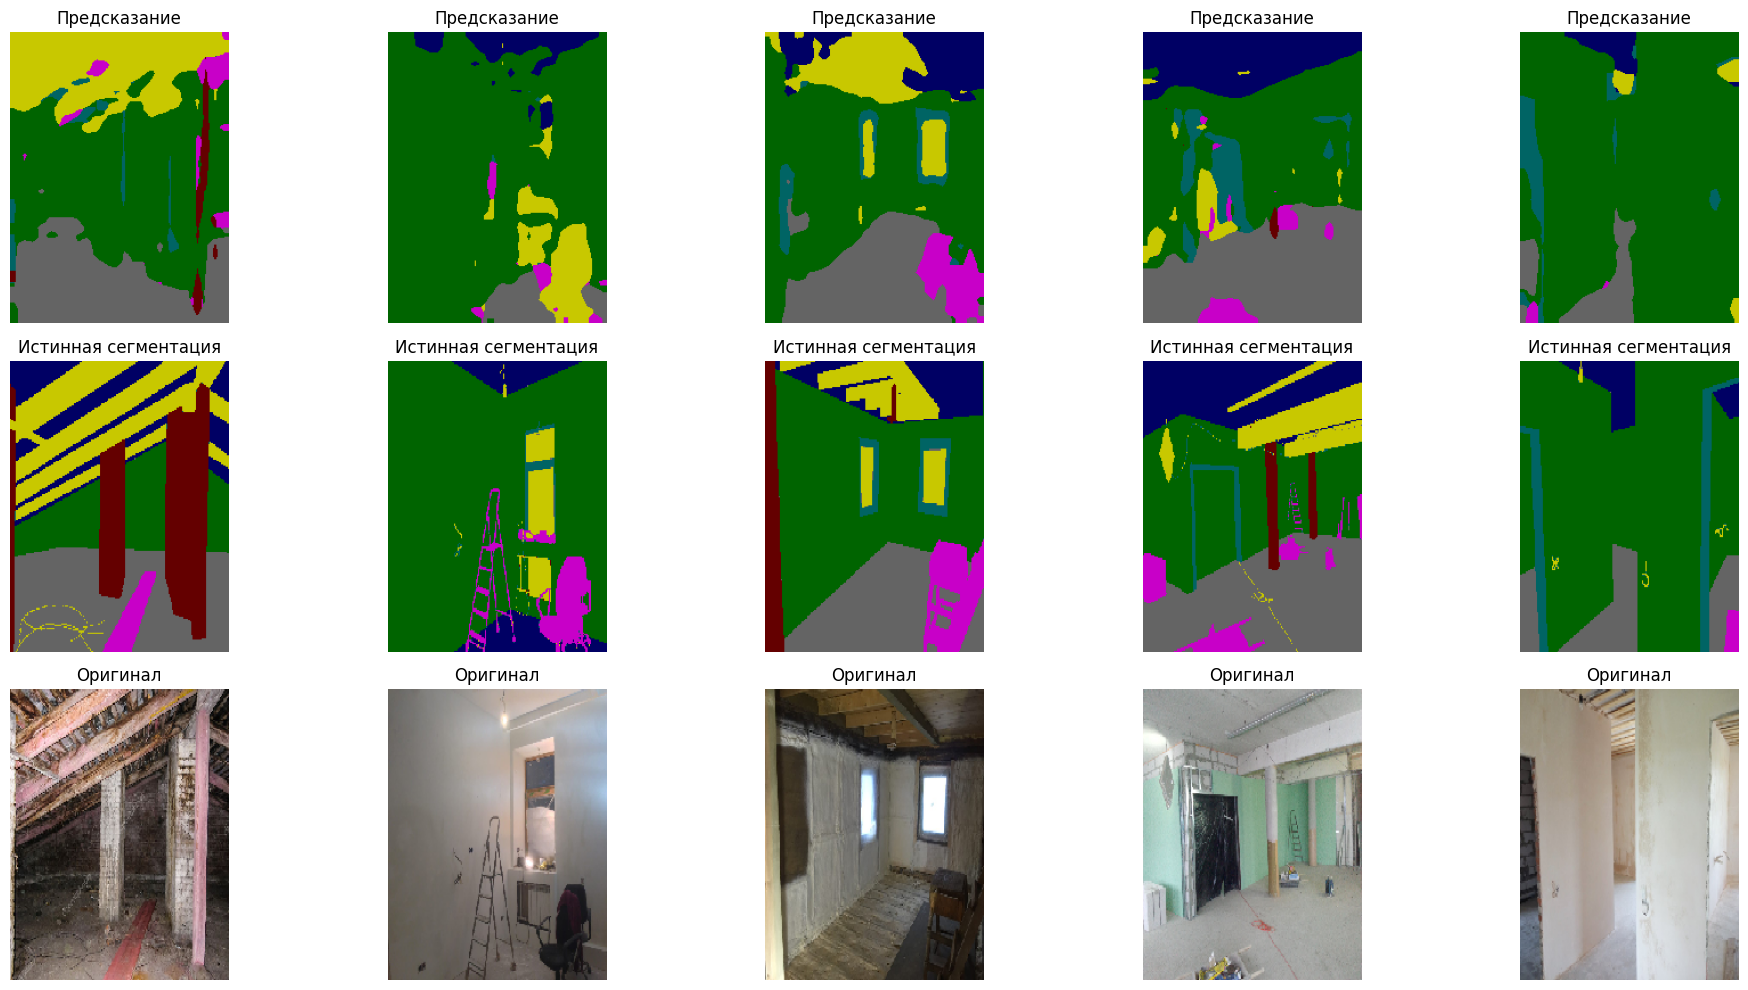

In [ ]:
# Визуализация результатов
process_images(model, 5)

# Вывод по заданию

В результате выполнения сделаем выводы: была реализована задача
семантической сегментации строительной базы с использованием модели
PSPNet. Основной целью стало сокращение исходного числа классов объектов
с
шестнадцати до семи, что позволило упростить структуру задачи и
адаптировать модель под ключевые категории.

На этапе подготовки данных была реализована функция преобразования
масок изображений из формата RGB в числовые метки классов. Это позволило
модели корректно интерпретировать входные данные и обучаться на них.
Маски были созданы таким образом, чтобы объединять смежные категории в
более общие группы, что повысило устойчивость модели к ошибкам
классификации.  

Сама модель сегментации была построена на основе архитектуры
PSPNet, которая использует пирамидальную агрегацию признаков для захвата
контекстной информации на разных масштабах изображения. Такой подход
позволяет достичь более точного разделения объектов, особенно в сложных
сценах с пересекающимися или частично закрытыми элементами.

Для повышения устойчивости обучения и предотвращения сбоев,
связанных с ограничением оперативной памяти в среде выполнения, была
использована ручная сборка мусора с помощью вызова gc.collect() в процессе
обучения модели.  

Результаты
сегментации,
полученные
на
выходе
модели,
продемонстрировали уверенное разделение объектов по заданным классам.
Визуальный анализ показал, что модель успешно справляется с задачей
распознавания ключевых элементов строительной базы.